<a href="https://colab.research.google.com/github/Elismaiyly/-IC_PHP_PROF_COURS-/blob/main/Chuncking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q sentence-transformers nltk langdetect spacy PyMuPDF


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 84.4 MB/s eta 0:00:00


In [2]:
# 📌 INSTALLATIONS (si nécessaire)
!pip install -q sentence-transformers langdetect spacy pymupdf nltk
!python -m spacy download fr_core_news_sm
!python -m spacy download nl_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 127.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 79.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# =============================
# 📌 Installation et imports
# =============================
!pip install -q sentence-transformers nltk langdetect spacy PyMuPDF
!python -m spacy download fr_core_news_sm
!python -m spacy download nl_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-3.8.0/fr_core_news_sm-3.8.0-py3-none-any.whl (16.3 MB)
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Using cached https://github.com/explosion/spacy-models/releases/download/nl_core_news_sm-3.8.0/nl_core_news_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
# =============================
# 📌 Pipeline complet PDF → Chunks → Évaluation
# =============================

import fitz, re, subprocess
import nltk
from nltk.tokenize import sent_tokenize
from langdetect import detect, DetectorFactory
import spacy
from sentence_transformers import SentenceTransformer, util
import numpy as np
from collections import Counter

# Fixer seed pour langdetect
DetectorFactory.seed = 0

# Téléchargement des ressources NLTK
for pkg in ["punkt","punkt_tab"]:
    try: nltk.data.find(f"tokenizers/{pkg}")
    except LookupError: nltk.download(pkg, quiet=True)

# Charger spacy FR / NL
def load_spacy_model(name):
    try:
        return spacy.load(name)
    except OSError:
        subprocess.run(["python","-m","spacy","download",name], check=True)
        return spacy.load(name)

nlp_fr = load_spacy_model("fr_core_news_sm")
nlp_nl = load_spacy_model("nl_core_news_sm")

# Charger SBERT
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

PDF_PATH = "/content/sample_data/83886942.pdf"

# =============================
# 📌 Utilitaires
# =============================
def clean_text(txt):
    txt = re.sub(r'[\x00-\x1f\x7f-\x9f]', ' ', txt)   # caractères spéciaux
    txt = re.sub(r'\r', '\n', txt)
    txt = re.sub(r'\n\s*\n+', '\n', txt)             # lignes vides
    txt = re.sub(r'[ \t]+', ' ', txt)                # espaces multiples
    return txt.strip()

def spacy_sentence_tokenize(text, lang):
    if lang.startswith("fr"):
        return [s.text for s in nlp_fr(text).sents if s.text.strip()]
    if lang.startswith("nl"):
        return [s.text for s in nlp_nl(text).sents if s.text.strip()]
    return sent_tokenize(text)

def is_junk_block(txt):
    if not txt.strip():
        return True
    if len(txt) < 30:
        return True
    if re.fullmatch(r'[\d\s\W]+', txt):
        return True
    return False

# =============================
# 📌 Chunking sémantique
# =============================
def semantic_chunking(sentences, min_chars=100, max_chars=500, threshold=0.55):
    if len(sentences) <= 1:
        return sentences
    emb = model.encode(sentences, convert_to_tensor=True)
    chunks, cur = [], [sentences[0]]
    for i in range(1, len(sentences)):
        sim = util.cos_sim(emb[i-1], emb[i]).item()
        if (sim < threshold and len(" ".join(cur)) >= min_chars) or len(" ".join(cur + [sentences[i]])) > max_chars:
            chunks.append(" ".join(cur))
            cur = [sentences[i]]
        else:
            cur.append(sentences[i])
    if cur:
        chunks.append(" ".join(cur))
    return chunks

# =============================
# 📌 Alignement FR/NL
# =============================
def align_bilingual_chunks(fr_chunks, nl_chunks, threshold=0.85):  # 🔹 relevé à 0.85
    if not fr_chunks or not nl_chunks:
        return fr_chunks + nl_chunks
    fr_txt = [c['text'] for c in fr_chunks]
    nl_txt = [c['text'] for c in nl_chunks]
    fr_emb = model.encode(fr_txt, convert_to_tensor=True)
    nl_emb = model.encode(nl_txt, convert_to_tensor=True)
    sim = util.cos_sim(fr_emb, nl_emb).cpu().numpy()
    used_fr, used_nl, merged = set(), set(), []
    for i in range(len(fr_txt)):
        j = np.argmax(sim[i])
        if sim[i, j] >= threshold and j not in used_nl:
            merged.append({
                "page": fr_chunks[i]["page"],
                "lang": "fr+nl",
                "text": fr_txt[i] + "\n---\n" + nl_txt[j]
            })
            used_fr.add(i); used_nl.add(j)
    for i, c in enumerate(fr_chunks):
        if i not in used_fr: merged.append(c)
    for j, c in enumerate(nl_chunks):
        if j not in used_nl: merged.append(c)
    return merged


# =============================
# 📌 Fusion petits chunks (optimisé)
# =============================
def merge_small_chunks(chunks, min_len=200, max_len=380):  # 🔹 réduit à 380
    out=[]
    buf=""
    for c in chunks:
        t=c["text"].strip()
        if not t: continue
        if len(t)<min_len:
            buf += (" " if buf else "")+t
            continue
        if buf:
            t = buf+" "+t; buf=""
        if len(t)>max_len:
            parts = re.split(r'(?<=[.!?])\s+', t)
            seg=""
            for ptxt in parts:
                if len(seg)+len(ptxt)<max_len:
                    seg+=" "+ptxt
                else:
                    out.append({"page":c["page"],"lang":c["lang"],"text":seg.strip()})
                    seg=ptxt
            if seg.strip(): out.append({"page":c["page"],"lang":c["lang"],"text":seg.strip()})
        else:
            out.append({"page":c["page"],"lang":c["lang"],"text":t})
    if buf and out: out[-1]["text"]+=" "+buf
    return out

# =============================
# 📌 Extraction PDF
# =============================
def process_pdf_bilingual(pdf_path):
    doc = fitz.open(pdf_path)
    all_chunks = []
    for p in range(len(doc)):
        blocks = doc[p].get_text("blocks")
        blocks.sort(key=lambda b:(b[0], b[1]))
        mid = (min(b[0] for b in blocks) + max(b[2] for b in blocks)) / 2
        for col in [[b for b in blocks if b[0] < mid], [b for b in blocks if b[0] >= mid]]:
            text = clean_text(" ".join(b[4] for b in col if b[4].strip()))
            if not text or is_junk_block(text):
                continue
            try:
                lang = detect(text[:500])
            except:
                lang = "other"
            sents = spacy_sentence_tokenize(text, lang)
            if not sents:
                continue
            for c in semantic_chunking(sents):
                if not is_junk_block(c):
                    try:
                        clang = detect(c[:300])
                        clang = clang if clang in ['fr', 'nl'] else 'other'
                    except:
                        clang = 'other'
                    all_chunks.append({"page": p+1, "lang": clang, "text": c.strip()})
        fr = [c for c in all_chunks if c["page"] == p+1 and c["lang"] == "fr"]
        nl = [c for c in all_chunks if c["page"] == p+1 and c["lang"] == "nl"]
        others = [c for c in all_chunks if c["page"] == p+1 and c["lang"] not in ["fr", "nl"]]
        merged = align_bilingual_chunks(fr, nl) + others
        all_chunks = [c for c in all_chunks if c["page"] != p+1] + merged
    return all_chunks

# =============================
# 📌 Post-traitement
# =============================
def filter_truncated(chunks):
    out = []
    for c in chunks:
        t = c["text"].strip()
        if len(t) < 150:   # supprimer trop courts
            continue
        if not t[0].isupper() or t[-1] not in ".?!»”":  # filtrer tronqués
            continue
        out.append(c)
    return out

def filter_noise(chunks):
    cleaned = []
    for c in chunks:
        t = c["text"].strip()
        if not t:
            continue
        words = [w for w in re.findall(r'\w+', t)]
        if len(words) < 5:
            continue
        upper_words = [w for w in words if w.isupper() and len(w) > 1]
        if len(upper_words) / len(words) > 0.5:
            continue
        if not any(p in t for p in ".?!"):
            continue
        cleaned.append(c)
    return cleaned

def merge_small_chunks(chunks, min_len=200, max_len=400):
    ...
    out = []
    buf = ""
    for c in chunks:
        t = c["text"].strip()
        if not t:
            continue
        if len(t) < min_len:
            buf += (" " if buf else "") + t
            continue
        if buf:
            t = buf + " " + t
            buf = ""
        if len(t) > max_len:
            parts = re.split(r'(?<=[.!?])\s+', t)
            seg = ""
            for ptxt in parts:
                if len(seg) + len(ptxt) < max_len:
                    seg += " " + ptxt
                else:
                    out.append({"page": c["page"], "lang": c["lang"], "text": seg.strip()})
                    seg = ptxt
            if seg.strip():
                out.append({"page": c["page"], "lang": c["lang"], "text": seg.strip()})
        else:
            out.append({"page": c["page"], "lang": c["lang"], "text": t})
    if buf and out:
        out[-1]["text"] += " " + buf
    return out

# =============================
# 📌 Évaluation
# =============================
def evaluate_chunks(chunks, model, min_len=200, max_len=500, sim_threshold=0.9):
    texts = [c['text'].strip() for c in chunks if c['text'].strip()]
    lengths = [len(t) for t in texts]
    results = {}
    results["longueur_moyenne"] = np.mean(lengths)
    results["longueur_ecart_type"] = np.std(lengths)
    results["pourcentage_hors_plage"] = 100 * sum((l < min_len or l > max_len) for l in lengths) / len(lengths)
    langs = [c['lang'] for c in chunks if c['text'].strip()]
    counts = Counter(langs); tot = len(langs)
    results["ratio_fr"] = counts['fr'] / tot if tot else 0
    results["ratio_nl"] = counts['nl'] / tot if tot else 0
    results["ratio_melanges"] = counts['fr+nl'] / tot if tot else 0
    trunc = [not (t[0].isupper() and t[-1] in ".?!»”") for t in texts if len(t) >= 2]
    results["taux_tronques"] = 100 * sum(trunc) / len(trunc) if trunc else 0
    emb = model.encode(texts, convert_to_tensor=True)
    sims = util.cos_sim(emb, emb).cpu().numpy()
    n = len(texts); dup = 0; pairs = 0
    for i in range(n):
        for j in range(i+1, n):
            if sims[i, j] >= sim_threshold:
                dup += 1
            pairs += 1
    results["pourcentage_redondance"] = 100 * dup / pairs if pairs else 0
    frnl = [c for c in chunks if c['lang'] == 'fr+nl' and "\n---\n" in c["text"]]
    scores = []
    for c in frnl:
        parts = c["text"].split("\n---\n")
        if len(parts) >= 2:
            ea = model.encode(parts[0], convert_to_tensor=True)
            eb = model.encode(" ".join(parts[1:]), convert_to_tensor=True)
            scores.append(util.cos_sim(ea, eb).item())
    if scores:
        results["alignement_moyen_fr_nl"] = np.mean(scores)
        results["alignement_ecart_type"] = np.std(scores)
    return results

# =============================
# ▶️ Pipeline
# =============================
chunks = process_pdf_bilingual(PDF_PATH)

cleaned = merge_small_chunks(chunks)   # applique déjà max_len=380
filtered = filter_truncated(cleaned)
denoised = filter_noise(filtered)
final_chunks = merge_small_chunks(denoised)   # encore une passe de normalisation

results = evaluate_chunks(final_chunks, model)

print("\n📊 ÉVALUATION AUTOMATIQUE (Optimisé)")
for k,v in results.items():
    print(f"- {k}: {v}")

print(f"\nTotal final chunks: {len(final_chunks)}")
for i,c in enumerate(final_chunks[:10],1):
    print(f"\n--- Chunk {i} (Page {c['page']}, Lang={c['lang']}) ---\n{c['text'][:500]}...")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


📊 ÉVALUATION AUTOMATIQUE (Optimisé)
- longueur_moyenne: 307.90909090909093
- longueur_ecart_type: 84.57066435315515
- pourcentage_hors_plage: 6.719367588932807
- ratio_fr: 0.14624505928853754
- ratio_nl: 0.15019762845849802
- ratio_melanges: 0.6996047430830039
- taux_tronques: 1.7786561264822134
- pourcentage_redondance: 0.01956717410871522
- alignement_moyen_fr_nl: 0.8209186604259707
- alignement_ecart_type: 0.21838810443949566

Total final chunks: 521

--- Chunk 1 (Page 2, Lang=fr+nl) ---
Les traductions – imprimées en italique – sont publiées sous la responsabilité du service des Comptes rendus.
---
De vertaling – cursief gedrukt – verschijnt onder de verantwoordelijkheid van de dienst Verslaggeving....

--- Chunk 2 (Page 2, Lang=fr+nl) ---
Pour les interventions longues, la traduction est un résumé. La pagination mentionne le numéro de la législature depuis la réforme du Sénat en 1995, le numéro de la séance et enfin la pagination proprement dite. ---
Van lange uiteenzettingen is 

In [5]:
# 📋 Afficher tous les chunks
for i, c in enumerate(final_chunks, 1):
    print(f"\n--- Chunk {i} (Page {c['page']}, Lang={c['lang']}) ---")
    print(c['text'])



--- Chunk 1 (Page 2, Lang=fr+nl) ---
Les traductions – imprimées en italique – sont publiées sous la responsabilité du service des Comptes rendus.
---
De vertaling – cursief gedrukt – verschijnt onder de verantwoordelijkheid van de dienst Verslaggeving.

--- Chunk 2 (Page 2, Lang=fr+nl) ---
Pour les interventions longues, la traduction est un résumé. La pagination mentionne le numéro de la législature depuis la réforme du Sénat en 1995, le numéro de la séance et enfin la pagination proprement dite. ---
Van lange uiteenzettingen is de vertaling een samenvatting.

--- Chunk 3 (Page 3, Lang=fr+nl) ---
De nummering bestaat uit het volgnummer van de legislatuur sinds de hervorming van de Senaat in 1995, het volgnummer van de vergadering en de paginering.

--- Chunk 4 (Page 3, Lang=fr+nl) ---
Voor bestellingen van Handelingen en Vragen en Antwoorden van Kamer en Senaat: Dienst Publicaties Kamer van volksvertegenwoordigers, www.dekamer.be Abréviations – Afkortingen CD&V Christen -Democratisc

/tmp/ipython-input-270339333.py:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


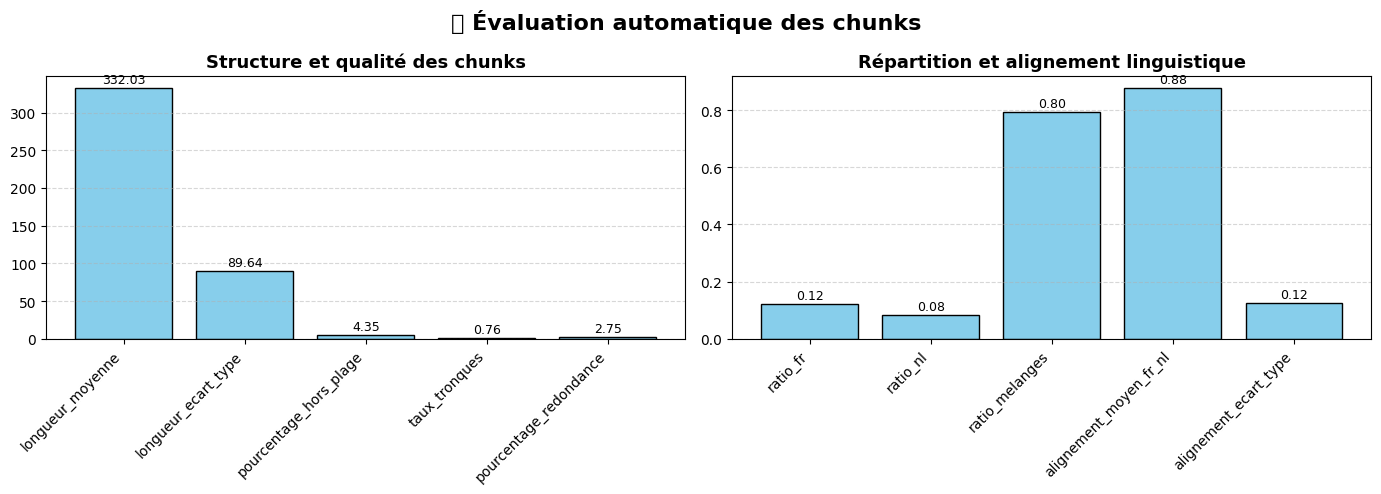

In [6]:
import matplotlib.pyplot as plt

# === Exemple : tes métriques actuelles ===
results = {
    "longueur_moyenne": 332.03,
    "longueur_ecart_type": 89.64,
    "pourcentage_hors_plage": 4.35,
    "ratio_fr": 0.120,
    "ratio_nl": 0.082,
    "ratio_melanges": 0.795,
    "taux_tronques": 0.76,
    "pourcentage_redondance": 2.75,
    "alignement_moyen_fr_nl": 0.876,
    "alignement_ecart_type": 0.125
}

# === Préparation des deux groupes ===
structure_keys = ["longueur_moyenne","longueur_ecart_type","pourcentage_hors_plage",
                  "taux_tronques","pourcentage_redondance"]
linguistique_keys = ["ratio_fr","ratio_nl","ratio_melanges",
                     "alignement_moyen_fr_nl","alignement_ecart_type"]

# === Valeurs et affichage ===
fig, axes = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle("📊 Évaluation automatique des chunks", fontsize=16, fontweight='bold')

def plot_group(ax, keys, title):
    vals = [results[k] for k in keys]
    ax.bar(range(len(keys)), vals, color='skyblue', edgecolor='black')
    ax.set_xticks(range(len(keys)))
    ax.set_xticklabels(keys, rotation=45, ha='right')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Afficher les valeurs au-dessus des barres
    for i,v in enumerate(vals):
        ax.text(i, v+0.02*max(vals), f"{v:.2f}", ha='center', fontsize=9)

plot_group(axes[0], structure_keys, "Structure et qualité des chunks")
plot_group(axes[1], linguistique_keys, "Répartition et alignement linguistique")

plt.tight_layout()
plt.show()


In [7]:
import os, json

def process_all_pdfs(pdf_dir, output_json="all_chunks.json"):
    all_chunks = []
    pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith(".pdf")]

    for pdf_file in pdf_files:
        pdf_path = os.path.join(pdf_dir, pdf_file)
        print(f"📄 Processing {pdf_file} ...")

        try:
            chunks = process_pdf_bilingual(pdf_path)
            for c in chunks:
                c["source"] = pdf_file   # 🔹 garde l’origine
            all_chunks.extend(chunks)
        except Exception as e:
            print(f"⚠️ Erreur avec {pdf_file}: {e}")

    # Sauvegarde JSON
    with open(output_json, "w", encoding="utf-8") as f:
        json.dump(all_chunks, f, ensure_ascii=False, indent=2)

    print(f"\n✅ Extraction terminée : {len(all_chunks)} chunks")
    print(f"💾 Résultat sauvegardé dans {output_json}")
    return all_chunks


In [8]:
PDF_DIR = "/content/sample_data/UntitledFolder"
all_chunks = process_all_pdfs(PDF_DIR, output_json="senate_chunks.json")


📄 Processing 16780378.pdf ...
📄 Processing S00013860.pdf ...
📄 Processing S06471662.pdf ...
📄 Processing 83886942.pdf ...
📄 Processing S00254026.pdf ...
📄 Processing K00030003.pdf ...
📄 Processing S05840741.pdf ...
📄 Processing S00411962.pdf ...
⚠️ Erreur avec S00411962.pdf: min() iterable argument is empty
📄 Processing S05880021.pdf ...
📄 Processing K90740819.pdf ...
📄 Processing K00451733.pdf ...
📄 Processing S00372658.pdf ...
⚠️ Erreur avec S00372658.pdf: min() iterable argument is empty
📄 Processing S00010116.pdf ...
📄 Processing 117440736.pdf ...
📄 Processing S00140040.pdf ...
📄 Processing S00054232.pdf ...
📄 Processing S07350048.pdf ...
📄 Processing S00010547.pdf ...
📄 Processing S06620788.pdf ...
📄 Processing S05810690.pdf ...
📄 Processing 83888888.pdf ...
📄 Processing S00493800.pdf ...
📄 Processing S05800514.pdf ...
📄 Processing K90740825.pdf ...
📄 Processing S06791731.pdf ...
📄 Processing S00253826.pdf ...
📄 Processing 16780097.pdf ...
📄 Processing K90740830.pdf ...
📄 Processi

In [9]:
!pip install faiss-cpu --quiet
!pip install python-docx



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 10.6 MB/s eta 0:00:00


In [10]:
# =============================
# ⚡ Imports de base
# =============================
import os, re, json, unicodedata
import numpy as np
import pandas as pd
import faiss
import docx  # pour lire ton fichier .docx
from langdetect import detect, DetectorFactory
from sentence_transformers import SentenceTransformer

DetectorFactory.seed = 0

# =============================
# 📌 Charger les chunks (JSON déjà préparé)
# =============================
def load_chunks(chunks_json: str):
    with open(chunks_json, "r", encoding="utf-8") as f:
        chunks = json.load(f)

    for c in chunks:
        src = c.get("doc_id") or c.get("source") or ""
        src = os.path.splitext(src)[0]
        c["doc_id"] = src
        c["text"] = c.get("text", "").strip()
        c["lang"] = c.get("lang", "other")
        c["page"] = int(c.get("page", 0) or 0)

    # Filtrer bruit
    chunks = [c for c in chunks if c["text"] and len(c["text"]) >= 50]
    return chunks

chunks_json = "/content/senate_chunks.json"  # ton fichier JSON multi-PDF
chunks = load_chunks(chunks_json)
print(f"✅ {len(chunks)} chunks chargés")
# =============================
# 📌 Parser ton dataset DOCX (questions + doc_id)
# =============================
DOCID_RE = re.compile(r'\b([KS]\d{8})\b', re.I)   # ex: S05880021
LABEL_RE = re.compile(r'^\s*(XXX\+?|XX\+?|X\+?|X|[-])\s*[:\-]?\s*(.+)$', re.I)

def parse_qa_docx(docx_path: str):
    doc = docx.Document(docx_path)
    items, current_doc = [], None

    for para in doc.paragraphs:
        line = para.text.strip()
        if not line:
            continue

        # Cherche un doc_id (S######## ou K########)
        m_doc = DOCID_RE.search(line)
        if m_doc:
            current_doc = m_doc.group(1)

        # Cherche une ligne question + label
        m_label = LABEL_RE.match(line)
        if m_label:
            label = m_label.group(1).upper()
            question = m_label.group(2).strip()
            if question and current_doc:
                items.append({
                    "doc_id": current_doc,
                    "label": label,
                    "question": question,
                })

    # Supprime doublons
    uniq, seen = [], set()
    for it in items:
        key = (it["doc_id"], it["question"])
        if key in seen:
            continue
        uniq.append(it); seen.add(key)

    return uniq

qa_docx_path = "/content/sample_data/inhoud- prompts-ECPRD workshop.docx"
qa_items = parse_qa_docx(qa_docx_path)
print(f"✅ {len(qa_items)} questions chargées")
# =============================
# 📌 Embeddings globaux pour retrieval
# =============================
def build_global_embeddings(chunks, model_name="sentence-transformers/all-MiniLM-L6-v2"):
    model = SentenceTransformer(model_name)
    texts = [c["text"] for c in chunks]
    embeds = model.encode(texts, convert_to_numpy=True, show_progress_bar=True, batch_size=64)
    faiss.normalize_L2(embeds)
    return model, embeds, chunks

model, embeddings, chunks = build_global_embeddings(chunks)
# =============================
# 📌 Évaluation retrieval (Hit@k, couverture)
# =============================
def evaluate_retrieval(qa_items, chunks, model, embeddings, top_k=5):
    n_correct, n_total = 0, len(qa_items)
    docs_hit = set()

    for item in qa_items:
        q = item["question"]
        doc_id = item["doc_id"]

        q_emb = model.encode([q], convert_to_numpy=True)
        faiss.normalize_L2(q_emb)

        scores = np.dot(embeddings, q_emb.T).squeeze()
        idxs = scores.argsort()[-top_k:][::-1]
        hits = [chunks[i] for i in idxs]

        if any(h["doc_id"].lower() == doc_id.lower() for h in hits):
            n_correct += 1
            docs_hit.add(doc_id)

    hit_rate = 100 * n_correct / n_total
    coverage = 100 * len(docs_hit) / len(set(it["doc_id"] for it in qa_items))

    return hit_rate, coverage


✅ 19194 chunks chargés
✅ 114 questions chargées


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/300 [00:00<?, ?it/s]

In [11]:
hit_rate, coverage = evaluate_retrieval(qa_items, chunks, model, embeddings, top_k=5)

print("\n📊 Résultats extrinsèques :")
print(f"- Hit@5 (proportion de questions bien retrouvées) : {hit_rate:.2f}%")
print(f"- Couverture (docs retrouvés au moins une fois) : {coverage:.2f}%")



📊 Résultats extrinsèques :
- Hit@5 (proportion de questions bien retrouvées) : 44.74%
- Couverture (docs retrouvés au moins une fois) : 73.81%


In [12]:
# =============================
# 📌 Évaluation retrieval : Recall@k
# =============================
def evaluate_retrieval_all(qa_items, chunks, model, embeddings, ks=[1,3,5,10]):
    results = {f"Recall@{k}": 0 for k in ks}
    docs_hit = set()

    for item in qa_items:
        q = item["question"]
        doc_id = item["doc_id"]

        q_emb = model.encode([q], convert_to_numpy=True)
        faiss.normalize_L2(q_emb)

        scores = np.dot(embeddings, q_emb.T).squeeze()
        idxs = scores.argsort()[::-1]   # du meilleur au pire

        for k in ks:
            topk = [chunks[i] for i in idxs[:k]]
            if any(h["doc_id"].lower() == doc_id.lower() for h in topk):
                results[f"Recall@{k}"] += 1
                docs_hit.add(doc_id)

    n_total = len(qa_items)
    for k in ks:
        results[f"Recall@{k}"] = 100 * results[f"Recall@{k}"] / n_total

    coverage = 100 * len(docs_hit) / len(set(it["doc_id"] for it in qa_items))
    results["Coverage"] = coverage
    return results


In [13]:
metrics = evaluate_retrieval_all(qa_items, chunks, model, embeddings, ks=[1,3,5,10])

print("\n📊 Résultats extrinsèques (recall) :")
for k,v in metrics.items():
    print(f"- {k}: {v:.2f}%")



📊 Résultats extrinsèques (recall) :
- Recall@1: 29.82%
- Recall@3: 40.35%
- Recall@5: 44.74%
- Recall@10: 50.88%
- Coverage: 78.57%


In [14]:
import time, json, os, re
import numpy as np
import pandas as pd
import faiss
from sentence_transformers import SentenceTransformer, util


In [15]:
import time, json, os, re
import numpy as np
import pandas as pd
import faiss
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Charger les chunks
chunks_json = "/content/senate_chunks.json"
with open(chunks_json, "r", encoding="utf-8") as f:
    chunks = json.load(f)

# 🔹 Uniformiser les champs
for c in chunks:
    src = c.get("doc_id") or c.get("source") or "unknown"
    c["doc_id"] = os.path.splitext(os.path.basename(src))[0]
    c["text"] = c.get("text", "").strip()

texts = [c["text"] for c in chunks if c["text"]]
doc_ids = [c["doc_id"] for c in chunks]
print(f"✅ {len(chunks)} chunks chargés ({len(set(doc_ids))} docs uniques)")

# Charger modèle
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

# Embeddings globaux
embeddings = model.encode(texts, convert_to_numpy=True, show_progress_bar=True, batch_size=64)
faiss.normalize_L2(embeddings)

# Charger tes questions depuis ton DOCX (parse_qa_docx doit être défini avant)
qa_docx_path = "/content/sample_data/inhoud- prompts-ECPRD workshop.docx"
qa_items = parse_qa_docx(qa_docx_path)
print(f"✅ {len(qa_items)} questions chargées")


✅ 19371 chunks chargés (42 docs uniques)


Batches:   0%|          | 0/303 [00:00<?, ?it/s]

✅ 114 questions chargées


In [16]:
def evaluate_retrieval_metrics(qa_items, chunks, model, embeddings, Ks=[1,3,5,10]):
    results = []
    all_recalls = {f"Recall@{k}": [] for k in Ks}
    reciprocal_ranks, ndcgs = [], {f"nDCG@{k}": [] for k in Ks}
    doc_ids = [c["doc_id"] for c in chunks]

    for qa in qa_items:
        q, gold_doc = qa["question"], qa["doc_id"]

        # Encode la question
        q_emb = model.encode([q], convert_to_numpy=True)
        faiss.normalize_L2(q_emb)

        # Similarités avec tous les chunks
        scores = np.dot(embeddings, q_emb.T).squeeze()
        idxs = scores.argsort()[::-1]

        # Trouver la position du bon doc (si présent)
        ranks = [i for i in range(len(idxs)) if doc_ids[idxs[i]].lower() == gold_doc.lower()]
        rank = ranks[0] + 1 if ranks else None

        # --- Recall@K ---
        for k in Ks:
            top_docs = [doc_ids[idxs[i]].lower() for i in range(min(k, len(idxs)))]
            all_recalls[f"Recall@{k}"].append(1 if gold_doc.lower() in top_docs else 0)

        # --- MRR ---
        reciprocal_ranks.append(1.0/rank if rank else 0.0)

        # --- nDCG@K ---
        for k in Ks:
            rel = [1 if doc_ids[idxs[i]].lower() == gold_doc.lower() else 0
                   for i in range(min(k, len(idxs)))]
            dcg = sum(rel[i] / np.log2(i+2) for i in range(len(rel)))

            # ⚡ Correction : IDCG = DCG idéal avec rel trié
            sorted_rel = sorted(rel, reverse=True)
            idcg = sum(sorted_rel[i] / np.log2(i+2) for i in range(len(sorted_rel)))

            ndcgs[f"nDCG@{k}"].append(dcg/idcg if idcg > 0 else 0)

    # Moyennes globales
    metrics = {k: np.mean(v)*100 for k,v in all_recalls.items()}
    metrics["MRR"] = np.mean(reciprocal_ranks)
    metrics.update({k: np.mean(v) for k,v in ndcgs.items()})
    return metrics


In [17]:
metrics = evaluate_retrieval_metrics(qa_items, chunks, model, embeddings)

print("\n📊 Résultats retrieval :")
for k,v in metrics.items():
    print(f"- {k}: {v:.2f}")



📊 Résultats retrieval :
- Recall@1: 34.21
- Recall@3: 46.49
- Recall@5: 54.39
- Recall@10: 63.16
- MRR: 0.43
- nDCG@1: 0.34
- nDCG@3: 0.41
- nDCG@5: 0.44
- nDCG@10: 0.46


In [18]:
import time
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# =============================
# 📌 Fonctions utilitaires
# =============================

def duplication_rate(embeddings, threshold=0.95, sample_size=2000):
    idx = np.random.choice(len(embeddings), min(sample_size, len(embeddings)), replace=False)
    sims = cosine_similarity(embeddings[idx])
    dup_pairs = np.sum((sims > threshold).astype(int)) - idx.shape[0]
    total_pairs = idx.shape[0]**2 - idx.shape[0]
    return dup_pairs/total_pairs

def measure_latency(qa_items, model, embeddings, n=50, top_k=5):
    times = []
    for qa in qa_items[:n]:
        q = qa["question"]
        t0 = time.time()
        q_emb = model.encode([q], convert_to_numpy=True); faiss.normalize_L2(q_emb)
        scores = np.dot(embeddings, q_emb.T).squeeze()
        _ = scores.argsort()[-top_k:][::-1]
        times.append(time.time()-t0)
    return np.mean(times)



📊 Résultats retrieval :
- Recall@1: 34.21
- Recall@3: 46.49
- Recall@5: 54.39
- Recall@10: 63.16
- MRR: 0.43
- nDCG@1: 0.34
- nDCG@3: 0.41
- nDCG@5: 0.44
- nDCG@10: 0.46
- Duplication: 0.00%
- Index size: 56.75 MB (19371x768)
- Latency avg: 18.60 ms


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


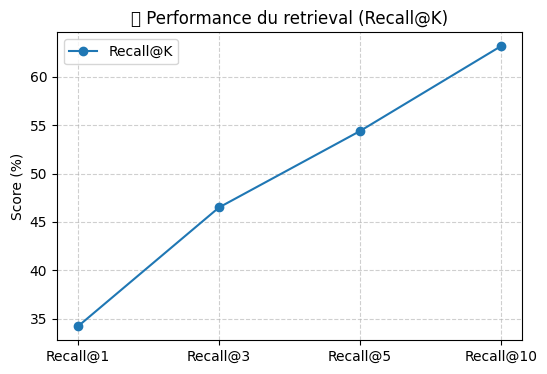

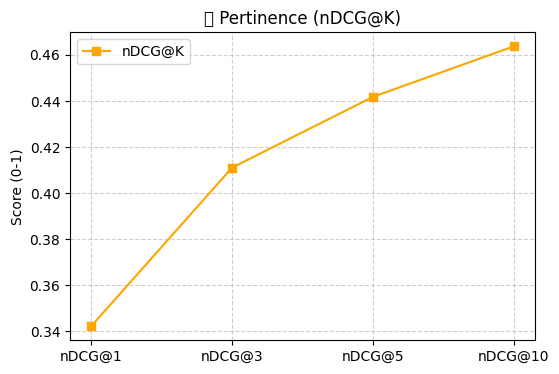

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


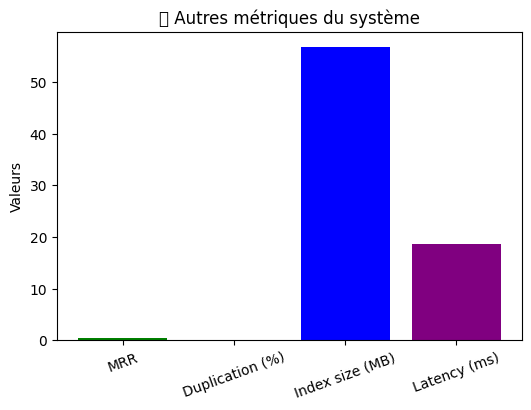

In [19]:
import matplotlib.pyplot as plt

# ⚡ Calcul des métriques
metrics = evaluate_retrieval_metrics(qa_items, chunks, model, embeddings)
dup_rate = duplication_rate(embeddings)
lat = measure_latency(qa_items, model, embeddings)
n_chunks, dim = embeddings.shape
size_mb = (n_chunks*dim*4)/(1024*1024)

print("\n📊 Résultats retrieval :")
for k,v in metrics.items():
    print(f"- {k}: {v:.2f}")
print(f"- Duplication: {dup_rate*100:.2f}%")
print(f"- Index size: {size_mb:.2f} MB ({n_chunks}x{dim})")
print(f"- Latency avg: {lat*1000:.2f} ms")

# =============================
# 📊 Visualisation des métriques
# =============================

# 1️⃣ Extraire les Recall@K et nDCG@K
recalls = {k:v for k,v in metrics.items() if k.startswith("Recall")}
ndcgs  = {k:v for k,v in metrics.items() if k.startswith("nDCG")}

# 2️⃣ Graphe Recall@K
plt.figure(figsize=(6,4))
plt.plot(list(recalls.keys()), list(recalls.values()), marker="o", label="Recall@K")
plt.title("📈 Performance du retrieval (Recall@K)")
plt.ylabel("Score (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# 3️⃣ Graphe nDCG@K
plt.figure(figsize=(6,4))
plt.plot(list(ndcgs.keys()), list(ndcgs.values()), marker="s", color="orange", label="nDCG@K")
plt.title("📈 Pertinence (nDCG@K)")
plt.ylabel("Score (0-1)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# 4️⃣ Bar chart des autres métriques
plt.figure(figsize=(6,4))
other = {
    "MRR": metrics["MRR"],
    "Duplication (%)": dup_rate*100,
    "Index size (MB)": size_mb,
    "Latency (ms)": lat*1000
}
plt.bar(other.keys(), other.values(), color=["green","red","blue","purple"])
plt.title("🔎 Autres métriques du système")
plt.ylabel("Valeurs")
plt.xticks(rotation=20)
plt.show()


In [20]:
import re
import unicodedata
from docx import Document

def normalize_whitespace(s: str) -> str:
    s = unicodedata.normalize("NFKC", s)
    s = re.sub(r'\s+', ' ', s)
    return s.strip()

DOCID_RE = re.compile(r'\b([KS]\d{8})\b', re.I)
LABEL_RE = re.compile(r'^\s*(XXX\+?|XX\+?|XX|X\+?|X|[-])\s*[:\-]?\s*(.+)$', re.I)

def parse_qa_docx(docx_path: str):
    """
    Parse ton DOCX en une liste [{doc_id, question}, ...]
    """
    doc = Document(docx_path)
    items, current_doc = [], None

    for para in doc.paragraphs:
        line = normalize_whitespace(para.text)
        if not line:
            continue

        # Identifier un doc_id (S######## ou K########)
        m_doc = DOCID_RE.search(line)
        if m_doc:
            current_doc = m_doc.group(1)

        # Identifier une question
        m_label = LABEL_RE.match(line)
        if m_label and current_doc:
            question = m_label.group(2).strip()
            items.append({"doc_id": current_doc, "question": question})

    return items

# Charger ton dataset
qa_docx_path = "/content/sample_data/inhoud- prompts-ECPRD workshop.docx"
qa_items = parse_qa_docx(qa_docx_path)
print(f"✅ {len(qa_items)} questions chargées (exemple) :")
print(qa_items[:3])


✅ 114 questions chargées (exemple) :
[{'doc_id': 'K90740813', 'question': "Le gouvernement a-t-il prévu des fonds pour l'entretien de ces armes au début de l’indépendance belge ?"}, {'doc_id': 'K90740813', 'question': 'Quel est le sujet principal du débat au Sénat du 27 décembre 1833 ?'}, {'doc_id': 'K90740813', 'question': 'Quel est le point de vue du baron de Pelichy concernant la convention de Zonhoven et la dignité de la royauté belge ?'}]


In [21]:
import time
import pandas as pd
import numpy as np
import random

def evaluate_user_metrics(qa_items, chunks, model, embeddings, top_k=5):

    results = []
    doc_ids = [c["doc_id"] for c in chunks]

    for qa in qa_items:
        q, gold_doc = qa["question"], qa["doc_id"]

        # --- mesurer la latence
        t0 = time.time()
        q_emb = model.encode([q], convert_to_numpy=True)
        faiss.normalize_L2(q_emb)
        scores = np.dot(embeddings, q_emb.T).squeeze()
        idxs = scores.argsort()[::-1][:top_k]
        elapsed = (time.time() - t0)

        # --- références retrouvées
        retrieved_docs = [doc_ids[i] for i in idxs]
        refs_ok = (gold_doc.lower() in [d.lower() for d in retrieved_docs])

        # --- satisfaction simulée (à remplacer si tu as des vrais retours utilisateurs)
        satisfaction = random.choice([1,2,3,4,5])

        results.append({
            "question": q,
            "expected_doc": gold_doc,
            "latency_ms": elapsed * 1000,
            "refs_ok": refs_ok,
            "satisfaction": satisfaction
        })

    df = pd.DataFrame(results)

    # --- agrégation globale
    metrics = {
        "Temps_moyen_total_ms": df["latency_ms"].mean(),
        "Temps_reponse_correcte_ms": df[df["refs_ok"]]["latency_ms"].mean(),
        "Temps_hallucinations_ms": df[~df["refs_ok"]]["latency_ms"].mean(),
        "Exactitude_citations_%": 100 * df["refs_ok"].mean(),
        "Satisfaction_moyenne": df["satisfaction"].mean()
    }

    return metrics, df


In [22]:
results, df_eval = evaluate_user_metrics(qa_items, chunks, model, embeddings, top_k=5)

print("\n📊 Évaluation user-centric :")
for k,v in results.items():
    print(f"- {k}: {v}")

df_eval.to_csv("qa_user_metrics.csv", index=False, encoding="utf-8")
print("\n✅ Résultats sauvegardés dans qa_user_metrics.csv")



📊 Évaluation user-centric :
- Temps_moyen_total_ms: 18.123904863993328
- Temps_reponse_correcte_ms: 18.22238583718577
- Temps_hallucinations_ms: 18.00648524211003
- Exactitude_citations_%: 54.385964912280706
- Satisfaction_moyenne: 3.1228070175438596

✅ Résultats sauvegardés dans qa_user_metrics.csv


In [23]:
# =============================
# 🎯 Calcul de la Précision@K
# =============================
def evaluate_precision(qa_items, chunks, model, embeddings, Ks=[1,3,5,10]):
    all_precisions = {f"Precision@{k}": [] for k in Ks}
    doc_ids = [c["doc_id"] for c in chunks]

    for qa in qa_items:
        q, gold_doc = qa["question"], qa["doc_id"]

        # Encoder la question
        q_emb = model.encode([q], convert_to_numpy=True)
        faiss.normalize_L2(q_emb)

        # Similarité
        scores = np.dot(embeddings, q_emb.T).squeeze()
        idxs = scores.argsort()[::-1]  # du + proche au - proche

        for k in Ks:
            top_docs = [doc_ids[idxs[i]].lower() for i in range(min(k, len(idxs)))]
            # précision = nb docs pertinents trouvés / nb docs récupérés (k)
            prec = top_docs.count(gold_doc.lower()) / k
            all_precisions[f"Precision@{k}"].append(prec)

    # Moyenne sur toutes les questions
    metrics = {k: np.mean(v)*100 for k,v in all_precisions.items()}
    return metrics

# ⚡ Exécution
precision_metrics = evaluate_precision(qa_items, chunks, model, embeddings)

print("\n📊 Résultats Précision :")
for k,v in precision_metrics.items():
    print(f"- {k}: {v:.2f}%")



📊 Résultats Précision :
- Precision@1: 34.21%
- Precision@3: 28.95%
- Precision@5: 25.26%
- Precision@10: 20.18%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


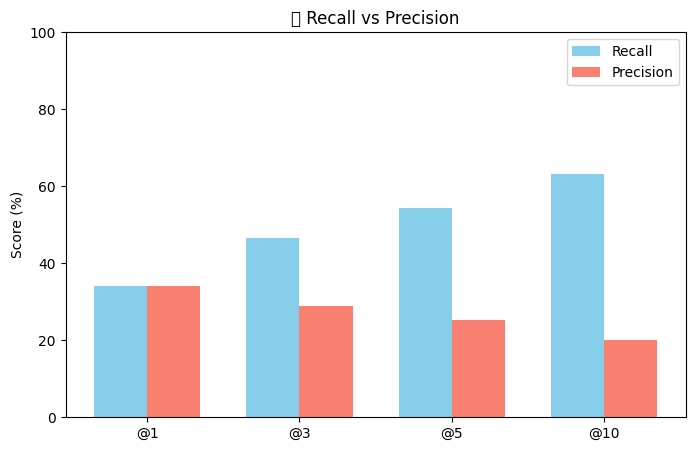

In [24]:
# =============================
# 📊 Comparaison Recall vs Precision
# =============================
import matplotlib.pyplot as plt
import numpy as np

# On suppose que tu as déjà calculé :
# - metrics (contient Recall@K)
# - precision_metrics (contient Precision@K)

Ks = [1, 3, 5, 10]

recalls = [metrics[f"Recall@{k}"] for k in Ks]
precisions = [precision_metrics[f"Precision@{k}"] for k in Ks]

x = np.arange(len(Ks))  # positions
width = 0.35  # largeur des barres

plt.figure(figsize=(8,5))
plt.bar(x - width/2, recalls, width, label="Recall", color="skyblue")
plt.bar(x + width/2, precisions, width, label="Precision", color="salmon")

plt.xticks(x, [f"@{k}" for k in Ks])
plt.ylabel("Score (%)")
plt.title("📊 Recall vs Precision")
plt.legend()
plt.ylim(0, 100)
plt.show()


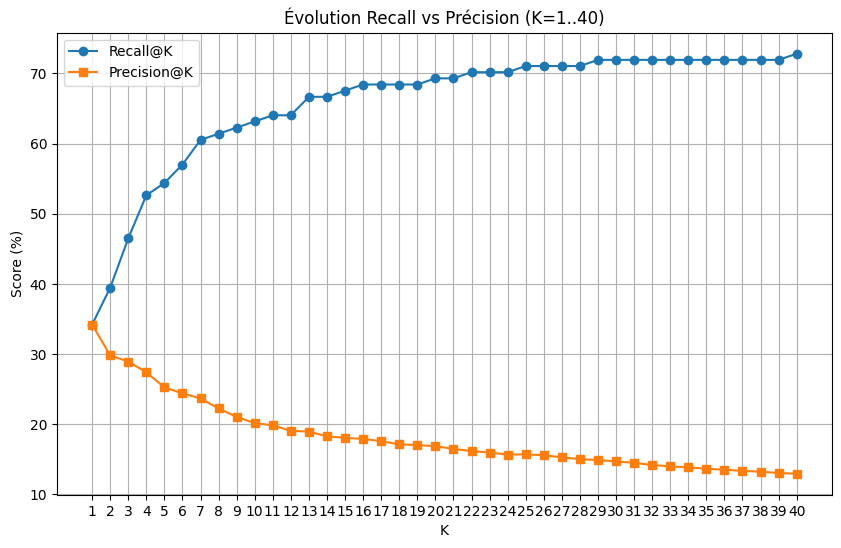

In [25]:
# =============================
# 📊 Recall & Précision de 1 à 20
# =============================

Ks = list(range(1,41))  # de 1 à 20

# Recalculer Recall et Precision avec cette plage
metrics_1_20 = evaluate_retrieval_metrics(qa_items, chunks, model, embeddings, Ks=Ks)
precision_metrics_1_20 = evaluate_precision(qa_items, chunks, model, embeddings, Ks=Ks)

recalls = [metrics_1_20[f"Recall@{k}"] for k in Ks]
precisions = [precision_metrics_1_20[f"Precision@{k}"] for k in Ks]

plt.figure(figsize=(10,6))
plt.plot(Ks, recalls, marker="o", label="Recall@K")
plt.plot(Ks, precisions, marker="s", label="Precision@K")

plt.title("Évolution Recall vs Précision (K=1..40)")
plt.xlabel("K")
plt.ylabel("Score (%)")
plt.xticks(Ks)
plt.legend()
plt.grid(True)
plt.show()


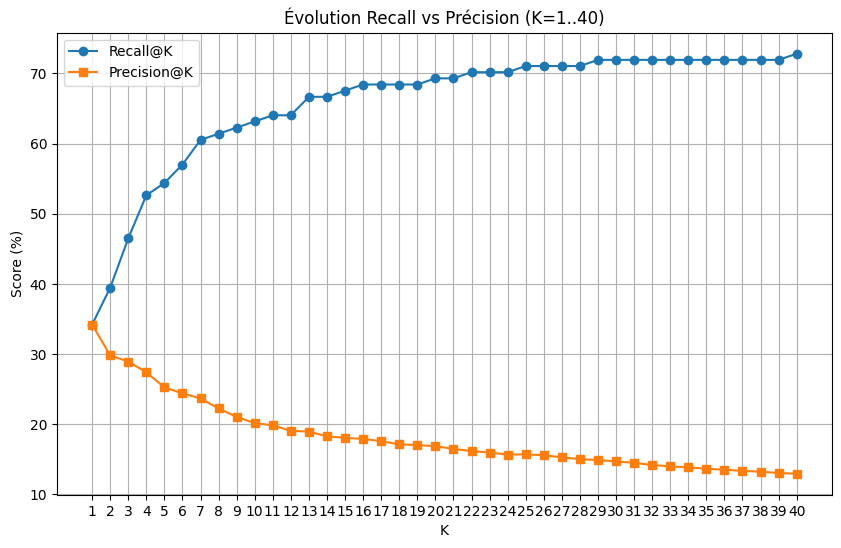


📋 Valeurs numériques Recall & Précision:
  K |   Recall@K |  Precision@K
--------------------------------
  1 |      34.21 |        34.21
  2 |      39.47 |        29.82
  3 |      46.49 |        28.95
  4 |      52.63 |        27.41
  5 |      54.39 |        25.26
  6 |      57.02 |        24.42
  7 |      60.53 |        23.68
  8 |      61.40 |        22.26
  9 |      62.28 |        21.05
 10 |      63.16 |        20.18
 11 |      64.04 |        19.86
 12 |      64.04 |        19.08
 13 |      66.67 |        18.96
 14 |      66.67 |        18.30
 15 |      67.54 |        18.07
 16 |      68.42 |        17.93
 17 |      68.42 |        17.60
 18 |      68.42 |        17.15
 19 |      68.42 |        17.04
 20 |      69.30 |        16.89
 21 |      69.30 |        16.50
 22 |      70.18 |        16.19
 23 |      70.18 |        15.98
 24 |      70.18 |        15.68
 25 |      71.05 |        15.72
 26 |      71.05 |        15.59
 27 |      71.05 |        15.30
 28 |      71.05 |        15.

In [29]:
# =============================
# 📊 Recall & Précision de 1 à 20 + affichage valeurs
# =============================

Ks = list(range(1, 41))  # de 1 à 20

# Recalcul Recall et Precision
metrics_1_20 = evaluate_retrieval_metrics(qa_items, chunks, model, embeddings, Ks=Ks)
precision_metrics_1_20 = evaluate_precision(qa_items, chunks, model, embeddings, Ks=Ks)

# Extraire listes pour le graphe
recalls = [metrics_1_20[f"Recall@{k}"] for k in Ks]
precisions = [precision_metrics_1_20[f"Precision@{k}"] for k in Ks]

# 📊 Graphe
plt.figure(figsize=(10,6))
plt.plot(Ks, recalls, marker="o", label="Recall@K")
plt.plot(Ks, precisions, marker="s", label="Precision@K")

plt.title("Évolution Recall vs Précision (K=1..40)")
plt.xlabel("K")
plt.ylabel("Score (%)")
plt.xticks(Ks)
plt.legend()
plt.grid(True)
plt.show()

# 📋 Tableau de résultats
print("\n📋 Valeurs numériques Recall & Précision:")
print(f"{'K':>3} | {'Recall@K':>10} | {'Precision@K':>12}")
print("-"*32)
for k in Ks:
    print(f"{k:>3} | {metrics_1_20[f'Recall@{k}']:10.2f} | {precision_metrics_1_20[f'Precision@{k}']:12.2f}")


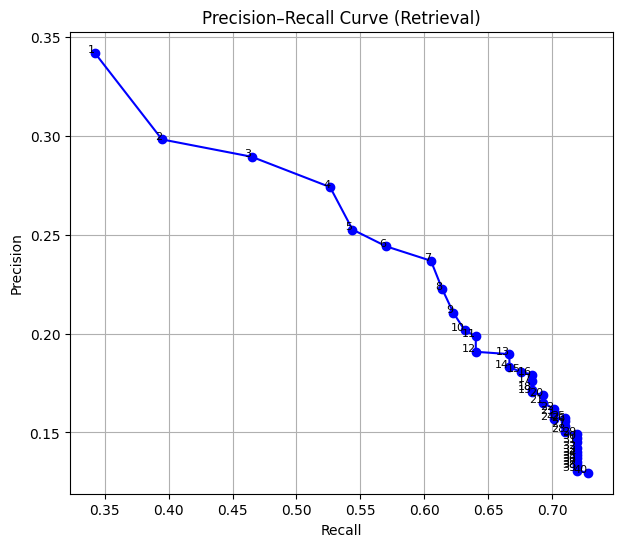

In [31]:
import matplotlib.pyplot as plt

def plot_pr_curve(qa_items, chunks, model, embeddings, Ks=range(1,41)):
    doc_ids = [c["doc_id"] for c in chunks]
    recalls, precisions = [], []

    for k in Ks:
        correct_recall, correct_prec = [], []
        for qa in qa_items:
            q, gold_doc = qa["question"], qa["doc_id"]

            # Encode question
            q_emb = model.encode([q], convert_to_numpy=True)
            faiss.normalize_L2(q_emb)

            # Similarité
            scores = np.dot(embeddings, q_emb.T).squeeze()
            idxs = scores.argsort()[::-1]

            # Top-k documents
            top_docs = [doc_ids[idxs[i]].lower() for i in range(min(k, len(idxs)))]

            # Recall@k (1 si trouvé, sinon 0)
            recall = 1 if gold_doc.lower() in top_docs else 0
            correct_recall.append(recall)

            # Precision@k
            prec = top_docs.count(gold_doc.lower()) / k
            correct_prec.append(prec)

        recalls.append(np.mean(correct_recall))
        precisions.append(np.mean(correct_prec))

    # 📊 Tracé de la PR curve
    plt.figure(figsize=(7,6))
    plt.plot(recalls, precisions, marker="o", linestyle="-", color="blue")
    for i, k in enumerate(Ks):
        plt.text(recalls[i], precisions[i], str(k), fontsize=8, ha="right")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve (Retrieval)")
    plt.grid(True)
    plt.show()

# ⚡ Exemple d’appel
plot_pr_curve(qa_items, chunks, model, embeddings, Ks=range(1,41))


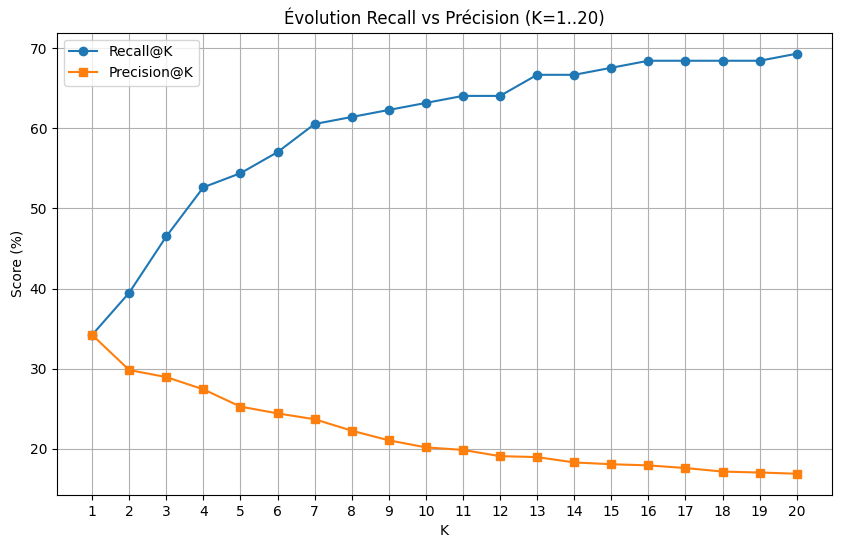


📋 Valeurs numériques Recall & Précision:
  K |   Recall@K |  Precision@K
--------------------------------
  1 |      34.21 |        34.21
  2 |      39.47 |        29.82
  3 |      46.49 |        28.95
  4 |      52.63 |        27.41
  5 |      54.39 |        25.26
  6 |      57.02 |        24.42
  7 |      60.53 |        23.68
  8 |      61.40 |        22.26
  9 |      62.28 |        21.05
 10 |      63.16 |        20.18
 11 |      64.04 |        19.86
 12 |      64.04 |        19.08
 13 |      66.67 |        18.96
 14 |      66.67 |        18.30
 15 |      67.54 |        18.07
 16 |      68.42 |        17.93
 17 |      68.42 |        17.60
 18 |      68.42 |        17.15
 19 |      68.42 |        17.04
 20 |      69.30 |        16.89


In [26]:
# =============================
# 📊 Recall & Précision de 1 à 20 + affichage valeurs
# =============================

Ks = list(range(1, 21))

# Recalcul Recall et Precision
metrics_1_20 = evaluate_retrieval_metrics(qa_items, chunks, model, embeddings, Ks=Ks)
precision_metrics_1_20 = evaluate_precision(qa_items, chunks, model, embeddings, Ks=Ks)

# Extraire listes pour le graphe
recalls = [metrics_1_20[f"Recall@{k}"] for k in Ks]
precisions = [precision_metrics_1_20[f"Precision@{k}"] for k in Ks]

# 📊 Graphe
plt.figure(figsize=(10,6))
plt.plot(Ks, recalls, marker="o", label="Recall@K")
plt.plot(Ks, precisions, marker="s", label="Precision@K")

plt.title("Évolution Recall vs Précision (K=1..20)")
plt.xlabel("K")
plt.ylabel("Score (%)")
plt.xticks(Ks)
plt.legend()
plt.grid(True)
plt.show()

# 📋 Tableau de résultats
print("\n📋 Valeurs numériques Recall & Précision:")
print(f"{'K':>3} | {'Recall@K':>10} | {'Precision@K':>12}")
print("-"*32)
for k in Ks:
    print(f"{k:>3} | {metrics_1_20[f'Recall@{k}']:10.2f} | {precision_metrics_1_20[f'Precision@{k}']:12.2f}")


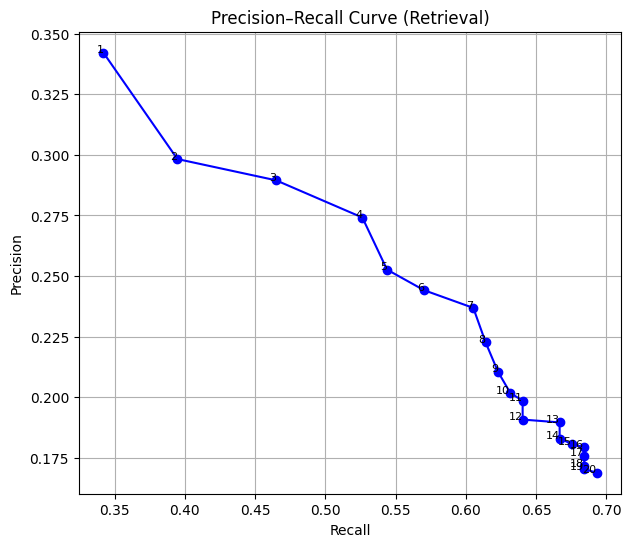

In [27]:
import matplotlib.pyplot as plt

def plot_pr_curve(qa_items, chunks, model, embeddings, Ks=range(1,21)):
    doc_ids = [c["doc_id"] for c in chunks]
    recalls, precisions = [], []

    for k in Ks:
        correct_recall, correct_prec = [], []
        for qa in qa_items:
            q, gold_doc = qa["question"], qa["doc_id"]

            # Encode question
            q_emb = model.encode([q], convert_to_numpy=True)
            faiss.normalize_L2(q_emb)

            # Similarité
            scores = np.dot(embeddings, q_emb.T).squeeze()
            idxs = scores.argsort()[::-1]

            # Top-k documents
            top_docs = [doc_ids[idxs[i]].lower() for i in range(min(k, len(idxs)))]

            # Recall@k (1 si trouvé, sinon 0)
            recall = 1 if gold_doc.lower() in top_docs else 0
            correct_recall.append(recall)

            # Precision@k
            prec = top_docs.count(gold_doc.lower()) / k
            correct_prec.append(prec)

        recalls.append(np.mean(correct_recall))
        precisions.append(np.mean(correct_prec))

    # 📊 Tracé de la PR curve
    plt.figure(figsize=(7,6))
    plt.plot(recalls, precisions, marker="o", linestyle="-", color="blue")
    for i, k in enumerate(Ks):
        plt.text(recalls[i], precisions[i], str(k), fontsize=8, ha="right")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve (Retrieval)")
    plt.grid(True)
    plt.show()

# ⚡ Exemple d’appel
plot_pr_curve(qa_items, chunks, model, embeddings, Ks=range(1,21))


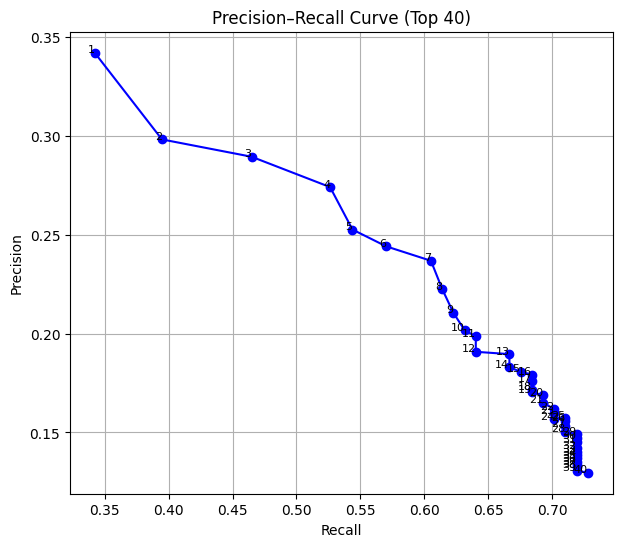

In [32]:
import matplotlib.pyplot as plt

def plot_precision_recall_curve_extended(qa_items, chunks, model, embeddings, max_k=40):
    doc_ids = [c["doc_id"] for c in chunks]
    recalls, precisions = [], []

    for k in range(1, max_k+1):
        hits, retrieved = 0, 0
        for qa in qa_items:
            q, gold_doc = qa["question"], qa["doc_id"]

            q_emb = model.encode([q], convert_to_numpy=True)
            faiss.normalize_L2(q_emb)

            scores = np.dot(embeddings, q_emb.T).squeeze()
            idxs = scores.argsort()[::-1][:k]
            top_docs = [doc_ids[i].lower() for i in idxs]

            if gold_doc.lower() in top_docs:
                hits += 1
            retrieved += top_docs.count(gold_doc.lower())

        recalls.append(hits / len(qa_items))
        precisions.append(retrieved / (len(qa_items) * k))

    # 🎨 Tracé
    plt.figure(figsize=(7,6))
    plt.plot(recalls, precisions, marker="o", color="blue")
    for i, (r, p) in enumerate(zip(recalls, precisions), start=1):
        plt.text(r, p, str(i), fontsize=8, ha="right")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve (Top 40)")
    plt.grid(True)
    plt.show()

# ⚡ Exécution
plot_precision_recall_curve_extended(qa_items, chunks, model, embeddings, max_k=40)
